# Data Analysis

## 0. Recap Data

First, the required modules have to be imported and the dataset has to be reloaded. More information on loading the data and the data set can be found in the notebook about data exploration.

In [1]:
import nilearn
from nilearn import datasets
import pandas as pd
from glob import glob
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

In [2]:
# Load the open data set ADHD 200 from nilearn
data = nilearn.datasets.fetch_adhd(n_subjects=40, data_dir='/mnt/c/Users/nasta/Desktop/Forschungsmodul/project_msc05/data', url=None, resume=True, verbose=1)

/home/nwiltberg/miniconda3/envs/neuro_ai/lib/python3.7/site-packages/nilearn/datasets/func.py:251: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [3]:
data['func'][0]

'/mnt/c/Users/nasta/Desktop/Forschungsmodul/project_msc05/data/adhd/data/0010042/0010042_rest_tshift_RPI_voreg_mni.nii.gz'

In [4]:
data.keys()

dict_keys(['func', 'confounds', 'phenotypic', 'description'])

In [5]:
data['confounds'][0]

'/mnt/c/Users/nasta/Desktop/Forschungsmodul/project_msc05/data/adhd/data/0010042/0010042_regressors.csv'

## 1. Extracting time series

The dataset contains resting state fmri data. In fmri, for each voxel in the brain the activity over time is being measured resulting in so called time series. These activation time-series are needed to compute a functional connectome, a set of connections representing brain interactions between regions. So they have to be extracted first. This is initially carried out for one participant as an example.

In [6]:
# set variables
rest_files = data['func'][0]
confound_files = data['confounds'][0]

As already mentioned in the notebook 'data exploration', the Yeo atlas is being used for brain parcellation. Since the parcelling is to be used to calculate the connectivity between the different regions, the altas must also be loaded here.

In [7]:
# Get Yeo atlas
atlas_yeo = datasets.fetch_atlas_yeo_2011(data_dir='/mnt/c/Users/nasta/Desktop/Forschungsmodul/project_msc05/data/yeo_atlas')

In [8]:
# set atlas
atlas_file = atlas_yeo.thick_7

Now, the'NiftiLabelsMasker' is being used to extract the signals on the parcellation.

In [9]:
# define masker for time series extraction
masker = NiftiLabelsMasker(labels_img=atlas_file, standardize=True, memory='nilearn_cache')

With 'fit_transform' the Nifti data is now turned to time-series. 

In [10]:
# apply masker to extract time series
time_series = masker.fit_transform(rest_files, confounds=confound_files)

In [11]:
# evaluate time series
time_series.shape

(176, 7)

In [12]:
# nilearn connectivity expects/wants time series stacked across participants (participants x time points x regions)
# thus, we have to reshape our time series to introduce a respective new dimension 
time_series = time_series.reshape(1,176,7)
time_series

array([[[-0.51034445, -0.29479277, -1.6705873 , ...,  0.28058898,
         -0.71294105,  0.22904894],
        [ 0.9958635 , -0.3302702 , -0.40546834, ..., -0.90956265,
         -0.2500286 , -0.2580618 ],
        [ 1.7991178 , -2.5736818 ,  0.18031912, ..., -0.574182  ,
         -0.01597627, -0.85473424],
        ...,
        [ 0.7255313 , -1.2795805 ,  0.43343168, ..., -0.40040085,
          0.865115  ,  0.51268786],
        [ 2.5853388 , -1.439889  ,  1.5045828 , ..., -1.1568449 ,
          1.2774026 , -0.49751338],
        [ 2.8541226 , -1.6701623 ,  0.60753673, ..., -0.2558145 ,
         -0.25552046, -1.1211945 ]]], dtype=float32)

## 2. Compute and display correlation matrix

In [13]:
# setup and apply connectivity measure to compute connectivity of regions across time points
connectome_measure = ConnectivityMeasure(kind='correlation')
correlation_matrices = connectome_measure.fit_transform(time_series)

In [14]:
# correlation matrix of course still has the extra dimension
correlation_matrices.shape

(1, 7, 7)

In [15]:
# as we work with data of one participant right now, lets just drop it
correlation_matrices = correlation_matrices.squeeze()
correlation_matrices.shape

(7, 7)

In [16]:
correlation_matrices

array([[ 1.        , -0.5145971 ,  0.16595417, -0.4575826 , -0.15901949,
        -0.32257894, -0.16459793],
       [-0.5145971 ,  1.        , -0.15548664,  0.64208764,  0.10796294,
         0.07630513, -0.19502069],
       [ 0.16595417, -0.15548664,  1.        , -0.11649854, -0.01312734,
         0.06357163, -0.29489803],
       [-0.4575826 ,  0.64208764, -0.11649854,  1.        ,  0.03280948,
         0.24299005, -0.45543557],
       [-0.15901949,  0.10796294, -0.01312734,  0.03280948,  1.        ,
        -0.04724521,  0.05450457],
       [-0.32257894,  0.07630513,  0.06357163,  0.24299005, -0.04724521,
         1.        , -0.07549269],
       [-0.16459793, -0.19502069, -0.29489803, -0.45543557,  0.05450457,
        -0.07549269,  1.        ]], dtype=float32)

In [17]:
# use nilearn to plot it
from nilearn.plotting import plot_matrix

In [18]:
# extract provided labels and make them ready for plotting
import pandas as pd
labels = pd.read_csv(atlas_yeo.colors_7, sep=' ')['Unnamed: 7'].to_numpy()

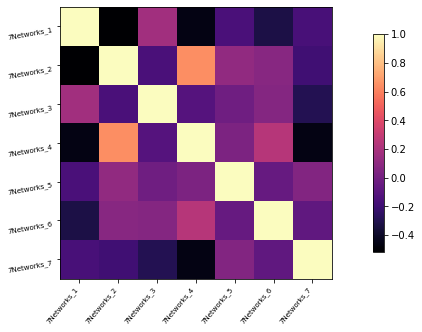

In [19]:
# plot connectivity matrix
plot_matrix(correlation_matrices, cmap='magma', labels=labels)

## 3. Extract time series and connectome for all participants

In [20]:
# extract time series from all subjects and concatenate them 
time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, confounds=confounds))

In [21]:
# calculate correlation matrices across subjects and display
correlation_matrices = connectome_measure.fit_transform(time_series)

In [23]:
# grab center coordinates for atlas labels
from nilearn import plotting
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_file)

In [25]:
# Mean correlation matrix across 10 subjects can be grabbed like this,
# using connectome measure object
mean_correlation_matrix = connectome_measure.mean_

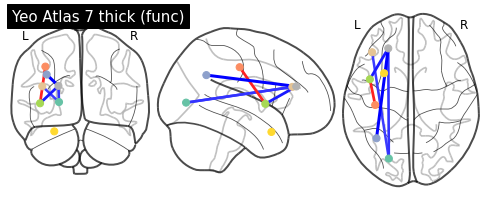

In [26]:
# plot connectome with 80% edge strength in the connectivity
plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="80%",
                         title='Yeo Atlas 7 thick (func)')

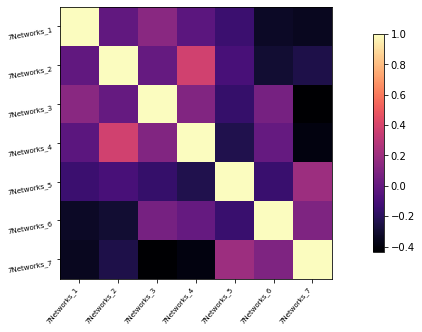

In [27]:
# plot mean connectivity matrix
plot_matrix(mean_correlation_matrix, cmap='magma', labels=labels)

### tasks & next steps

- write a `loop` that applies the above steps for each `participant`
    - what should be changed adapted?
    - hint: the `nilearn` tutorial shared during the meeting basically has everything
- what do the `connectivity matrices` reflect? 
- how would the `connectivity matrices` be utilized within the `analyzes`?
    - can they be used "as-is"?
    - if not, what should be changed?